<a href="https://colab.research.google.com/github/roguxivlo/machine-learning-24L/blob/main/hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

# General Setup

In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt

torch.manual_seed(42)
torch.cuda.manual_seed(42)

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.67MB/s]


In [2]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

# Task 1

In [3]:

# Get the LeNet5 model from our classes.

# Note: I had trouble getting appropriate training convergence using sigmoid activation
# The training works well for tanh activation function so I used this one.

import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=2)
        self.pool1 = torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
        self.pool2 = torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))

        self.linear1 = torch.nn.Linear(5*5*16, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        # print("Input min/max:", x.min().item(), x.max().item()) # Before conv1

        # TODO: add missing processing

        x = self.conv1(x)
        # print("Input to sigmoid (after conv1) min/max:", x.min().item(), x.max().item())
        x = F.tanh(x)
        # print("After conv1 sigmoid min/max:", x.min().item(), x.max().item()) # Should be 0-1

        x = self.pool1(x)
        x = F.tanh(self.conv2(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))

        x = self.dropout(x)
        x = self.linear3(x)

        return x

## Training LeNet5

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.2990927696228027
epoch: 0 batch: 1 current batch loss: 2.256777048110962
epoch: 0 batch: 2 current batch loss: 2.2130115032196045
epoch: 0 batch: 3 current batch loss: 2.1664199829101562
epoch: 0 batch: 4 current batch loss: 2.1174519062042236
epoch: 0 batch: 5 current batch loss: 2.0560665130615234
epoch: 0 batch: 6 current batch loss: 1.9834003448486328
epoch: 0 batch: 7 current batch loss: 1.9292776584625244
epoch: 0 batch: 8 current batch loss: 1.8510297536849976
epoch: 0 batch: 9 current batch loss: 1.7657214403152466
epoch: 0 batch: 10 current batch loss: 1.694237232208252
epoch: 0 batch: 11 current batch loss: 1.6145609617233276
epoch: 0 batch: 12 current batch loss: 1.5439139604568481
epoch: 0 batch: 13 current batch loss: 1.4951133728027344
epoch: 0 batch: 14 current batch loss: 1.4006738662719727
epoch: 0 batch: 15 current batch loss: 1.3458646535873413
epoch: 0 batch: 16 current batch loss: 1.2973848581314087
epoch: 0 b

## Now reuse Anti-MNIST from hw9

In [9]:
class Anti_MNIST(torch.nn.Module):
    def __init__ (self, trained_classifier):
        super().__init__()

        # Assure the model's weights are frozen
        trained_classifier.eval()
        for param in trained_classifier.parameters():
            param.requires_grad = False


        self.imgs = torch.nn.Parameter(torch.randn((10, 1, 28, 28)))
        self.classifier = trained_classifier # Ensure this is trained!

    def forward(self, _): # ignore x, we don't care
        output = self.classifier(self.imgs)
        return output

## Forgery without L2 penalty

In [11]:
anti_model = Anti_MNIST(net).to(device)
optimizer = torch.optim.Adam(anti_model.parameters(), 0.001)

anti_model.train()

goal_vector = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)

for epoch in range(5000):
    optimizer.zero_grad()
    output = anti_model(0) # x doesn't matter

    loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

    if (epoch + 1) % 500 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()

Epoch: 500, Current Loss: 0.0150
Epoch: 1000, Current Loss: 0.0054
Epoch: 1500, Current Loss: 0.0035
Epoch: 2000, Current Loss: 0.0022
Epoch: 2500, Current Loss: 0.0014
Epoch: 3000, Current Loss: 0.0013
Epoch: 3500, Current Loss: 0.0009
Epoch: 4000, Current Loss: 0.0010
Epoch: 4500, Current Loss: 0.0006
Epoch: 5000, Current Loss: 0.0006


### Show forgeries


Predicted labels for generated images: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


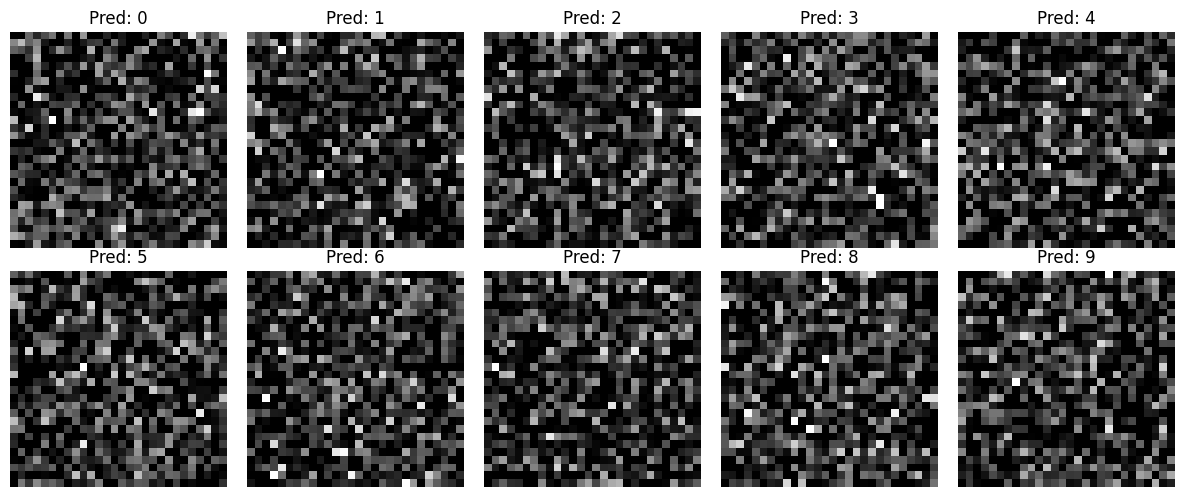

In [12]:
anti_model.eval()
with torch.no_grad():
    final_output = anti_model(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 rows, 5 columns for 10 images
axes = axes.flatten() # Flatten the 2x5 array of axes for easy iteration

for i in range(10):
    # Display each image
    axes[i].imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes[i].set_title(f"Pred: {predicted_labels[i].item()}")
    axes[i].axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

for reference: forgeries from hw9:
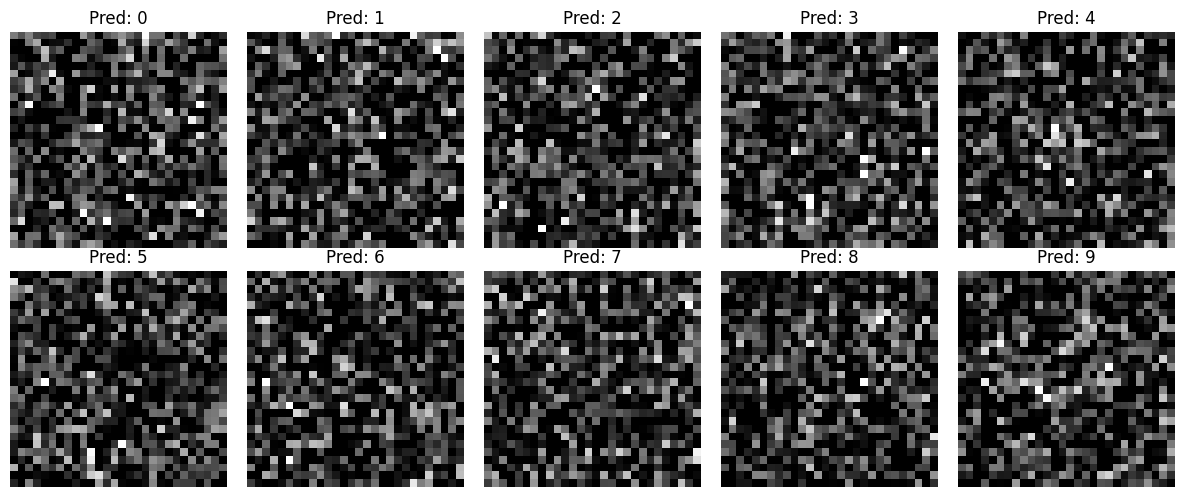

## Now Forgeries with L2 Penalty

In [32]:
anti_model_with_penalty = Anti_MNIST(net).to(device)
optimizer = torch.optim.Adam(anti_model_with_penalty.parameters(), 0.001)

anti_model_with_penalty.train()

goal_vector = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)

start_lambda_l2 = 0.001
end_lambda_l2 = 10.0

total_epochs = 10000

for epoch in range(total_epochs):
    optimizer.zero_grad()
    output = anti_model_with_penalty(0) # x doesn't matter

    loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

    exponent = epoch / (total_epochs - 1)
    current_lambda_l2 = start_lambda_l2 * (end_lambda_l2 / start_lambda_l2)**exponent

    l2_penalty = current_lambda_l2 * anti_model_with_penalty.imgs.pow(2).mean() # L2 penalty on pixel values

    total_loss = loss + l2_penalty

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

    total_loss.backward()       #this computes gradients as we have seen in previous workshops
    optimizer.step()

Epoch: 1000, Current Loss: 0.0043
Epoch: 2000, Current Loss: 0.0021
Epoch: 3000, Current Loss: 0.0013
Epoch: 4000, Current Loss: 0.0007
Epoch: 5000, Current Loss: 0.0007
Epoch: 6000, Current Loss: 0.0008
Epoch: 7000, Current Loss: 0.0012
Epoch: 8000, Current Loss: 0.0021
Epoch: 9000, Current Loss: 0.0040
Epoch: 10000, Current Loss: 0.0081


### Visualize forgeries


Predicted labels for generated images: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


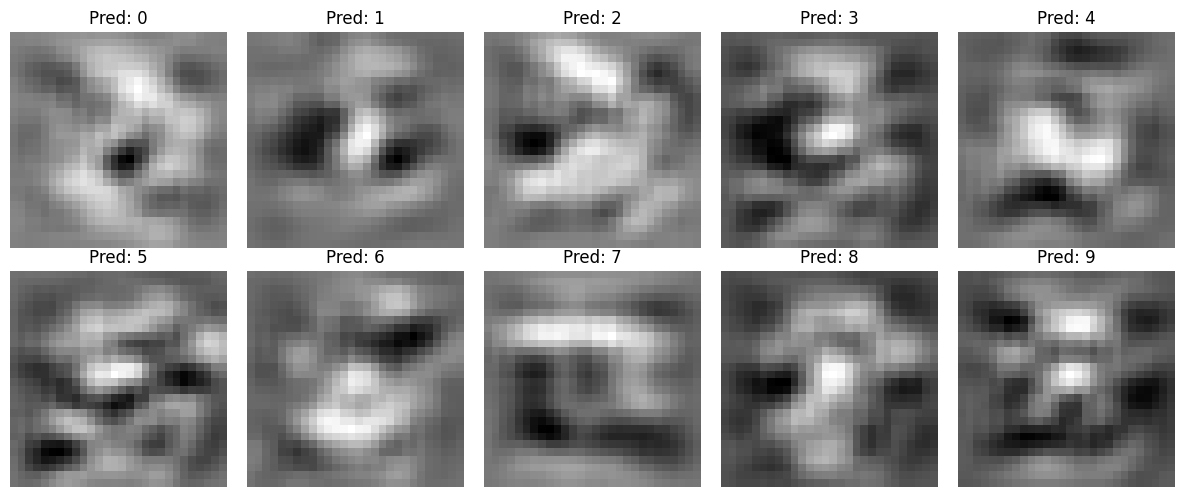

In [33]:
# Get the images from the anti_model_task_3a:

anti_model_with_penalty.eval()
with torch.no_grad():
    final_output = anti_model_with_penalty(0)
    predicted_labels = torch.argmax(final_output, dim=1)
    print(f"\nPredicted labels for generated images: {predicted_labels.tolist()}")


generated_images = anti_model_with_penalty.imgs.detach().cpu().squeeze(1).numpy()
# Define the mean and standard deviation used for original normalization
mean = 0.1307
std = 0.3081


denormalized_images = generated_images * std + mean
denormalized_images = denormalized_images.clip(0, 1) # Clamp values to be between 0 and 1


# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 rows, 5 columns for 10 images
axes = axes.flatten() # Flatten the 2x5 array of axes for easy iteration

for i in range(10):
    # Display each image
    axes[i].imshow(denormalized_images[i], cmap='gray')
    # Set title with the predicted label
    axes[i].set_title(f"Pred: {predicted_labels[i].item()}")
    axes[i].axis('off') # Hide axes ticks

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

for reference: results with L2 penalty from hw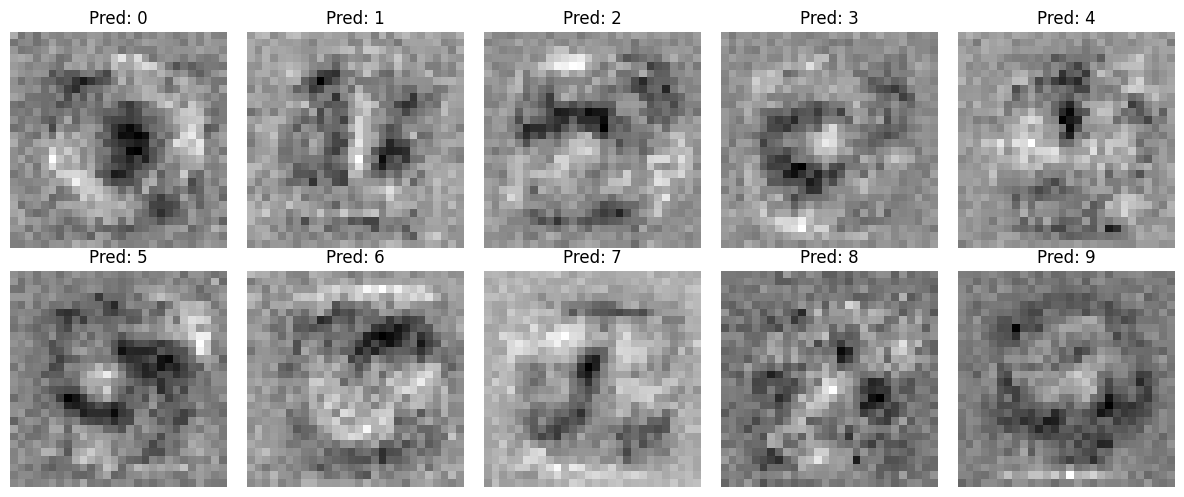

## Conclusions

There is no visible difference between forgeries of MLP and CNN when we don't use L2 penalty. The reasons are analogous to HW9. (i. e. there might be some not nice minima of the loss function)

However, when using L2 penalty, forgeries for CNN look a little better compared to forgeries for MLP. This might be due to the fact that CNN in principle tries to learn some general image features that are visible, for example edges, curves, etc.

Moreover, in MLP every neuron is connected to every other neuron from previous layer, whereas in CNN a more local connection is emphasized, which is arguably more natural

# Task 2

## Get the images

First, we need to select images that we will alter.

In [43]:
def get_selected_images_per_label(dataset, num_examples_per_label=9):
    """
    Selects a specified number of examples for each digit from a dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset (e.g., MNIST testset).
        num_examples_per_label (int): The number of examples to select for each digit.

    Returns:
        dict: A dictionary where keys are digit labels (0-9) and values are lists
              of selected image tensors.
    """
    selected_images = {i: [] for i in range(10)} # Initialize empty lists for each digit

    # Assuming dataset.targets is a tensor or list of labels
    # and dataset.data contains the image tensors
    for i in range(len(dataset)):
        image, label = dataset[i] # Get image and label for current item

        if len(selected_images[label]) < num_examples_per_label:
            selected_images[label].append(image)

        # Optional: break early if all examples are collected to save time
        all_collected = True
        for l in range(10):
            if len(selected_images[l]) < num_examples_per_label:
                all_collected = False
                break
        if all_collected:
            break

    # Convert lists of tensors to a single tensor for each label for convenience
    for label, img_list in selected_images.items():
        if len(img_list) > 0: # Check if any images were collected for this label
            selected_images[label] = torch.stack(img_list)
        else:
            print(f"Warning: Could not find {num_examples_per_label} examples for label {label}")

    return selected_images

In [46]:
examples = get_selected_images_per_label(testset)

print(examples[0].shape)



torch.Size([9, 1, 28, 28])

## Define the perturber model

In [51]:
class Perturber(torch.nn.Module):
    def __init__(self, image_to_perturb, trained_classifier):
        super().__init__()
        # Assure the model's weights are frozen
        trained_classifier.eval()
        for param in trained_classifier.parameters():
            param.requires_grad = False

        self.original_image = image_to_perturb
        self.perturbation = torch.nn.Parameter(torch.zeros_like(image_to_perturb))
        self.classifier = trained_classifier



    def forward(self, _):
        return self.classifier(self.original_image + self.perturbation)

In [76]:
def perturb_image(image_to_perturb, trained_classifier, goal_label, epochs = 5000):
    perturber = Perturber(image_to_perturb, trained_classifier)
    optimizer = torch.optim.Adam(perturber.parameters(), 0.001)

    perturber.train()

    goal_vector = torch.zeros(1, 10, device=device) # Shape (1, 10)
    goal_vector[0, goal_label] = 1.0 # Set the 1.0 for the correct class in the batch

    lambda_l2 = 1

    for epoch in range(epochs):

        optimizer.zero_grad()
        output = perturber(0) # x doesn't matter

        loss = torch.nn.functional.cross_entropy(output, goal_vector, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        l2_penalty = lambda_l2 * perturber.perturbation.pow(2).mean() # L2 penalty on pixel values


        if (epoch + 1) % 1000 == 0:
            print(f"Epoch: {epoch+1}, Current Loss: {loss.item():.4f}")

        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()

    return perturber.perturbation.detach().cpu()


In [77]:
# Example perturbation

image_to_perturb = torch.unsqueeze(examples[0][0], 0).to(device)
goal_label = 1

perturbation = perturb_image(image_to_perturb, net, goal_label)

Epoch: 1000, Current Loss: 0.2175
Epoch: 2000, Current Loss: 0.0497
Epoch: 3000, Current Loss: 0.0206
Epoch: 4000, Current Loss: 0.0112
Epoch: 5000, Current Loss: 0.0065


In [78]:
# Function for displaying perturbed image along with original
def perturb_and_display(image, goal_label):
    image = torch.unsqueeze(image, 0).to(device)
    perturbation = torch.squeeze(perturb_image(image, net, goal_label))

    image = torch.squeeze(image).detach().cpu()

    perturbed_image = perturbation + image

    # Define the mean and standard deviation used for original normalization
    mean = 0.1307
    std = 0.3081

    # denormalize:
    image = image * std + mean
    image = image.clip(0, 1)

    perturbed_image = perturbed_image * std + mean
    perturbed_image = perturbed_image.clip(0, 1)




    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 2 rows, 5 columns for 10 images
    axes = axes.flatten() # Flatten the 2x5 array of axes for easy iteration

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("original_image")
    axes[0].axis('off') # Hide axes ticks

    axes[1].imshow(perturbed_image, cmap='gray')
    axes[1].set_title("perturbed_image")
    axes[1].axis('off') # Hide axes ticks


    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plot



Epoch: 1000, Current Loss: 0.0286
Epoch: 2000, Current Loss: 0.0133
Epoch: 3000, Current Loss: 0.0058
Epoch: 4000, Current Loss: 0.0087
Epoch: 5000, Current Loss: 0.0026


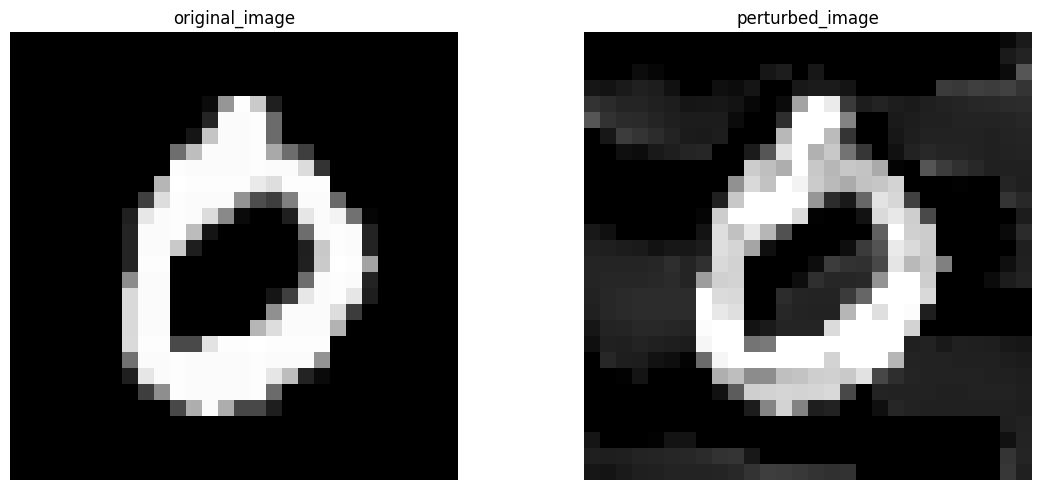

In [79]:
perturb_and_display(examples[0][0], 4)